In [59]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import os
from result_totals import plot_results
import requests
from config import google_key
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts

def import_data():
    global file_path 
    file_path = os.path.join("CSVs",'election_data_clean.csv')
    global elec_data
    elec_data = pd.read_csv(file_path,index_col=0,dtype = {3:str,4:str})
    global contests 
    contests = elec_data.groupby('Contest Code')
    global precincts
    precincts = elec_data.groupby('Precinct_Full_ID')
    

import_data()


In [2]:
results = plot_results(contest_name='State Representative',district=29,by_Precinct=True)['Response']
data = results['Data']
dist_29_precincts = [precincts.get_group(doc['scope'])['Precinct Polling Location'].unique()[0].split(' ',maxsplit=1) for doc in data]

C:\Users\spear_000\Anaconda3\lib\site-packages\pandas\core\indexing.py:1418: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


In [25]:
place_url = 'https://maps.googleapis.com/maps/api/place/findplacefromtext/json?'
details_url = 'https://maps.googleapis.com/maps/api/place/details/json?'


In [33]:
pct_locations = []
for i in range(len(dist_29_precincts)):
    url= place_url + f'input={dist_29_precincts[i][1]}' + '&'+ 'inputtype=textquery' +'&' + f'key={google_key}'
    place_id = requests.get(url).json()['candidates'][0]['place_id']
    search_url = details_url + f'place_id={place_id}' +'&' + f'key={google_key}'
    response = requests.get(search_url).json()
    pct_locations.append({dist_29_precincts[i][0]:{'name':response['result']['name'],'location': response['result']['geometry']['location']}})

In [74]:
for doc in pct_locations:
    pct_id = list(doc.keys())[0]
    name = doc[pct_id]['name']
    location = doc[pct_id]['location']
    print(f"{pct_id}:{name} = {location}")

001:Seminole Community Church = {'lat': 28.82695199999999, 'lng': -81.349542}
002:Lighthouse Baptist Church = {'lat': 28.83761599999999, 'lng': -81.635543}
003:Crossings Community Church = {'lat': 28.8048119, 'lng': -81.36462990000001}
004:Safeharbor Christian Church = {'lat': 28.7970234, 'lng': -81.3171478}
005:Westview Baptist Church = {'lat': 28.7873947, 'lng': -81.3241384}
006:Westside Community Center/ Boys And Girls Center = {'lat': 28.8036252, 'lng': -81.28848839999999}
007:Markham Woods Presbyterian Church = {'lat': 28.7755855, 'lng': -81.3818155}
008:Courtyard by Marriott Orlando Lake Mary/North = {'lat': 28.757089, 'lng': -81.36665699999999}
009:Holy Cross Lake Mary = {'lat': 28.7575806, 'lng': -81.3533444}
010:The Lake Mary Events Center = {'lat': 28.76215, 'lng': -81.3230639}
011:Florida Department of Health in Seminole County - Sanford Location = {'lat': 28.7739106, 'lng': -81.2852905}
012:Markham Woods Seventh-day Adventist Church = {'lat': 28.7032167, 'lng': -81.3850056}

In [79]:
lat = []
lng = []
size = []
dem = []
for x in range(len(data)):
    doc = data[x]
    pct = list(pct_locations[x].keys())[0]
    pct_location = pct_locations[x][pct]['location']
    lat.append(pct_location['lat'])
    lng.append(pct_location['lng'])
    total = sum(doc['y'])
    size.append(total)
    dem.append(doc['y'][1]/total)
    
    

In [197]:
def zscore(x,x_mean,x_std):
    return (x-x_mean)/x_std

lat_mean = np.mean(lat)
lat_std = np.std(lat)
lat_norm = [zscore(x,lat_mean,lat_std) for x in lat]

lng_mean = np.mean(lng)
lng_std = np.std(lng)
lng_norm = [zscore(x,lng_mean,lng_std) for x in lng]

size_adj = [75*x for x in size/np.mean(size)]

blue = [0,0,1]
red = [1,0,0]
colors = []

dem_adj = [0.5+np.sign((x - 0.5))*(abs(2*((x - 0.5)))**0.6)/2 for x in dem]
for r in dem_adj:
    blue_part = [float(r)*x for x in blue]
    red_part = [float(1-r)*x for x in red]
    new_color = [sum(x) for x in zip(blue_part,red_part)]
    colors.append(new_color)

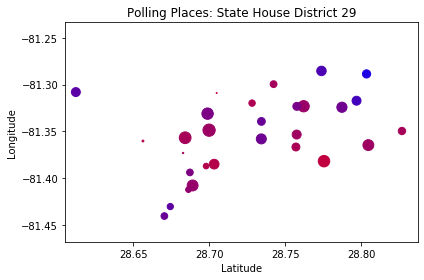

In [202]:
plt.scatter(lat,lng,s=size_adj,c=colors)
plt.xlim(lat_mean-0.359*lat_std,lat_mean-0.28*lat_std)
plt.ylim(lng_mean,lng_mean+0.1*lng_std)
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Polling Places: State House District 29')
plt.tight_layout(pad=1.08)
plt.savefig(os.path.join('..','docs','Visualizations','SH29_precinct_party_affiliation.png'))
plt.show()